In [1]:
# 📦 Imports y Configuración
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Configuración Visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

RANDOM_STATE = 42


---

## 2. El Problema de la Linealidad

La Regresión Logística dibuja una **línea recta** para separar clases. Pero, ¿qué pasa cuando los datos tienen forma de "lunas"? 🌙

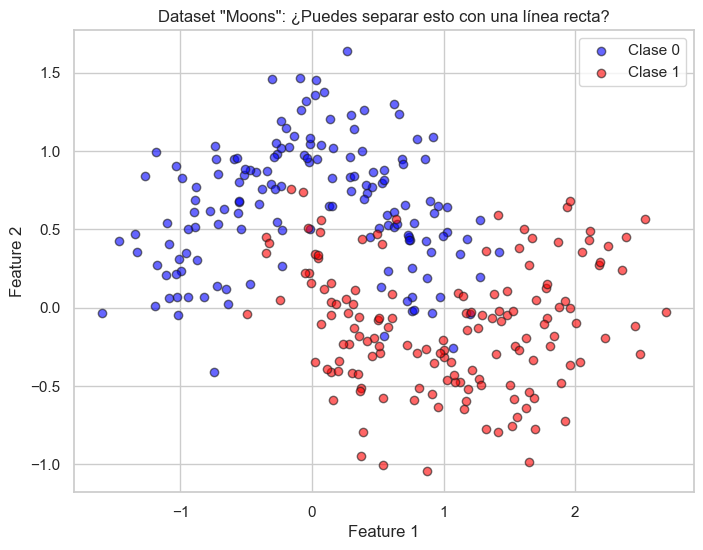

🤔 Una línea recta NO puede separar estas dos 'lunas' entrelazadas.
   Necesitamos un modelo que dibuje fronteras curvas o escalonadas.


In [2]:
# Generar datos en forma de lunas
X_moons, y_moons = make_moons(
    n_samples=300, noise=0.25, random_state=RANDOM_STATE)

plt.figure(figsize=(8, 6))
plt.scatter(X_moons[y_moons == 0, 0], X_moons[y_moons == 0, 1],
            c='blue', label='Clase 0', alpha=0.6, edgecolors='k')
plt.scatter(X_moons[y_moons == 1, 0], X_moons[y_moons == 1, 1],
            c='red', label='Clase 1', alpha=0.6, edgecolors='k')
plt.title('Dataset "Moons": ¿Puedes separar esto con una línea recta?')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

print("🤔 Una línea recta NO puede separar estas dos 'lunas' entrelazadas.")
print("   Necesitamos un modelo que dibuje fronteras curvas o escalonadas.")


---

## 3. ¿Cómo Funciona un Árbol de Decisión?

### El Algoritmo CART (Classification and Regression Trees)

1. **Pregunta:** ¿Feature X > valor umbral?
2. **Divide:** Separa los datos en dos grupos (izquierda/derecha)
3. **Repite:** Recursivamente hasta que las hojas sean "puras" o se alcance un límite

### 📐 Criterio de División: ¿Cómo elegir la mejor pregunta?

| Criterio | Fórmula | Interpretación |
|----------|---------|----------------|
| **Gini** | $1 - \sum p_i^2$ | Probabilidad de clasificación incorrecta |
| **Entropy** | $-\sum p_i \log_2(p_i)$ | Cantidad de "desorden" o incertidumbre |

**Objetivo:** En cada división, minimizar la impureza de los nodos hijos.

---

## 4. Simulación: Divide y Vencerás

Entrenaremos un árbol en el dataset "Moons" y visualizaremos su estructura.

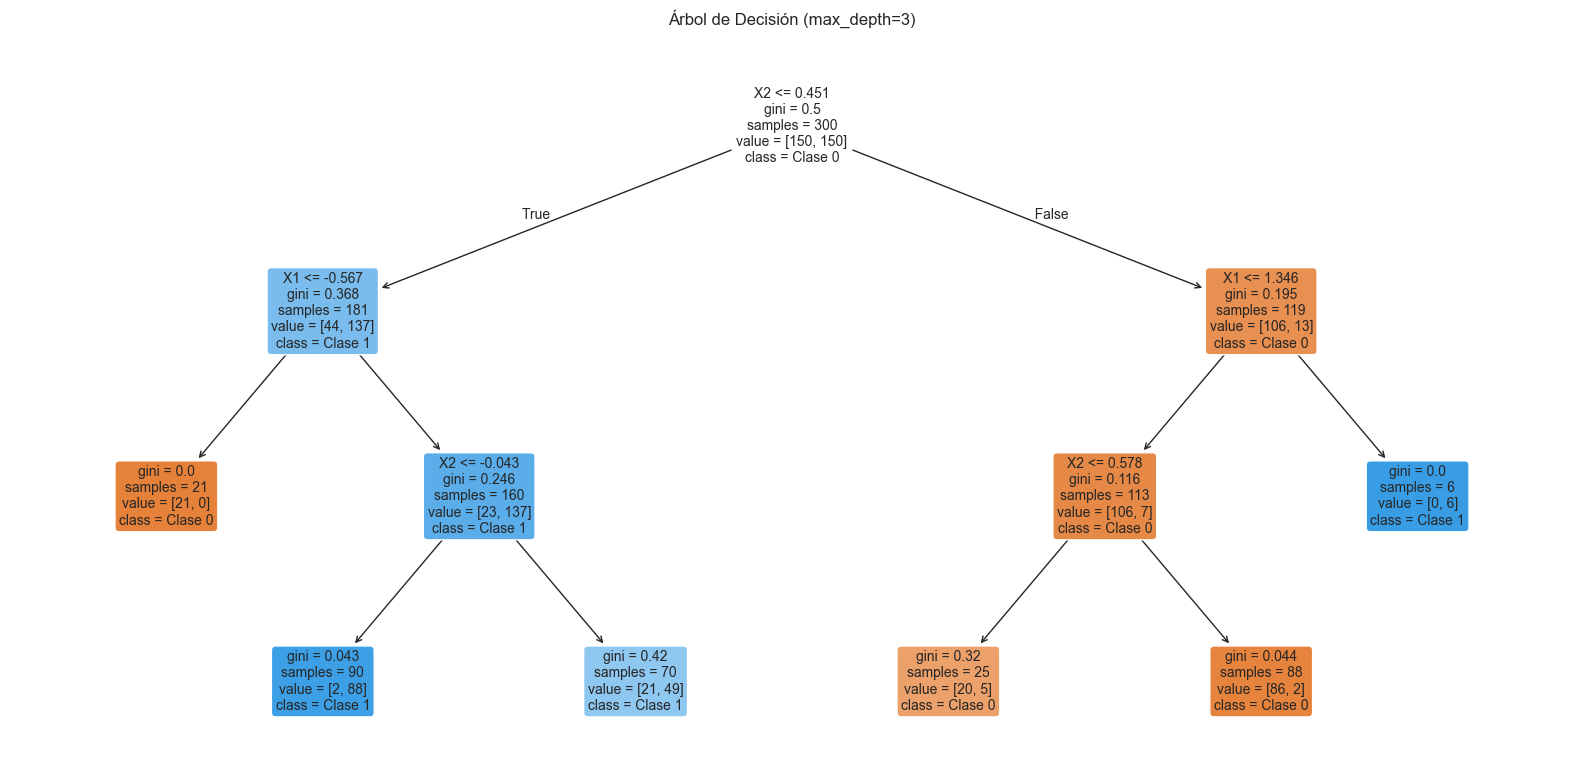

In [3]:
# Entrenar árbol con profundidad limitada
tree_simple = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)
tree_simple.fit(X_moons, y_moons)

# Visualizar el árbol
plt.figure(figsize=(16, 8))
plot_tree(tree_simple,
          feature_names=['X1', 'X2'],
          class_names=['Clase 0', 'Clase 1'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Árbol de Decisión (max_depth=3)')
plt.tight_layout()
plt.show()


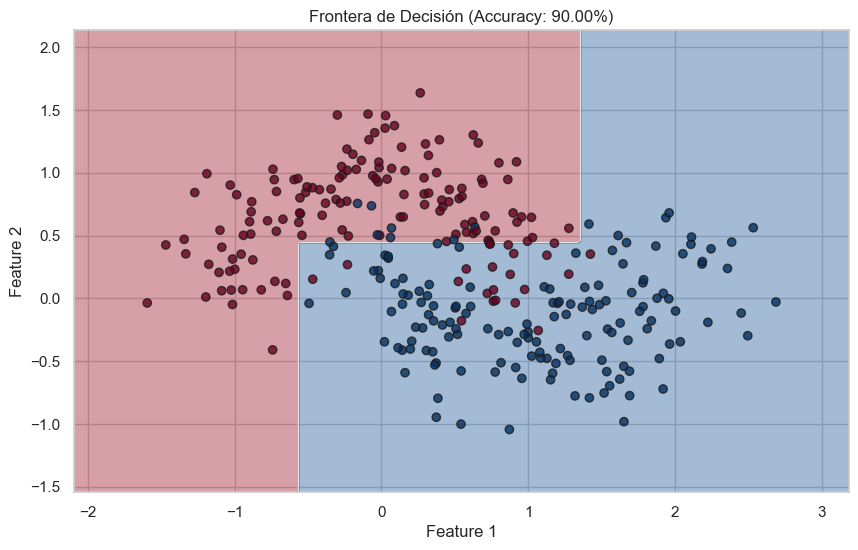

📊 Observa cómo el árbol crea fronteras 'escalonadas' (rectangulares).
   Cada división es paralela a uno de los ejes.


In [4]:
# Función para visualizar frontera de decisión
def plot_decision_boundary(model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='k', alpha=0.8)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')


# Visualizar frontera
plt.figure(figsize=(10, 6))
plot_decision_boundary(tree_simple, X_moons, y_moons,
                       f'Frontera de Decisión (Accuracy: {tree_simple.score(X_moons, y_moons):.2%})')
plt.show()

print("📊 Observa cómo el árbol crea fronteras 'escalonadas' (rectangulares).")
print("   Cada división es paralela a uno de los ejes.")


---

## 5. El Peligro del Overfitting

### ⚠️ ¿Qué pasa si dejamos crecer el árbol sin límites?

C:\Users\Theki\AppData\Local\Temp\ipykernel_44660\1599451133.py:26: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Theki\AppData\Local\Temp\ipykernel_44660\1599451133.py:26: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


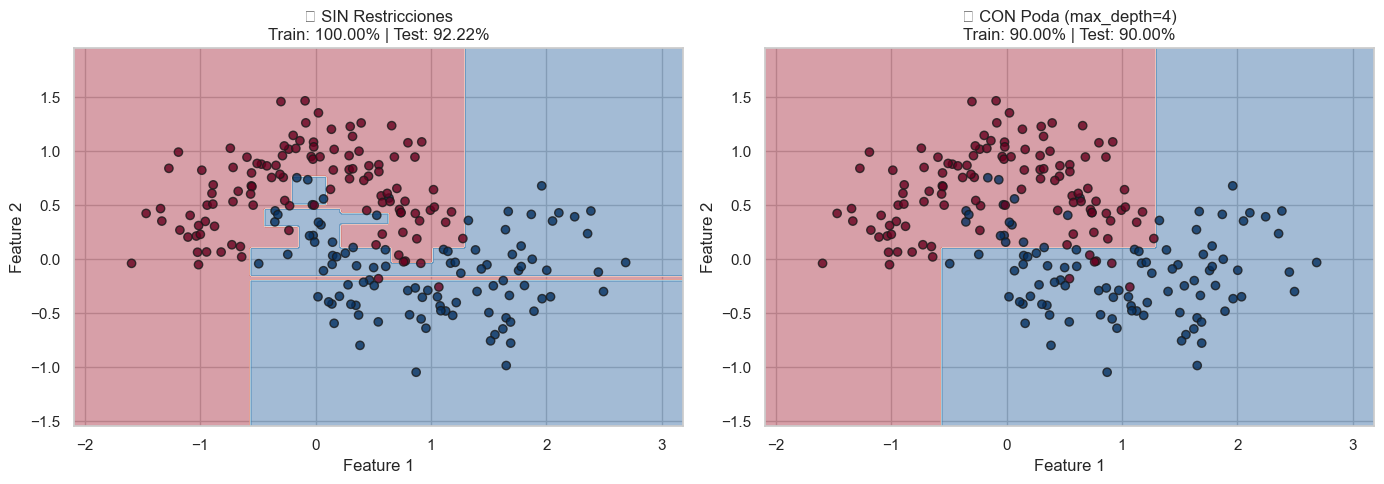

In [5]:
# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_moons, y_moons, test_size=0.3, random_state=RANDOM_STATE)

# Árbol SIN restricciones (overfitting)
tree_overfit = DecisionTreeClassifier(
    max_depth=None, random_state=RANDOM_STATE)
tree_overfit.fit(X_train, y_train)

# Árbol CON restricciones (poda)
tree_pruned = DecisionTreeClassifier(
    max_depth=4, min_samples_leaf=5, random_state=RANDOM_STATE)
tree_pruned.fit(X_train, y_train)

# Comparar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plt.sca(axes[0])
plot_decision_boundary(tree_overfit, X_train, y_train,
                       f'❌ SIN Restricciones\nTrain: {tree_overfit.score(X_train, y_train):.2%} | Test: {tree_overfit.score(X_test, y_test):.2%}')

plt.sca(axes[1])
plot_decision_boundary(tree_pruned, X_train, y_train,
                       f'✅ CON Poda (max_depth=4)\nTrain: {tree_pruned.score(X_train, y_train):.2%} | Test: {tree_pruned.score(X_test, y_test):.2%}')

plt.tight_layout()
plt.show()


> **💡 Pro-Tip: La Regla de la Raíz Cuadrada**
> Si tu árbol tiene más hojas que $\sqrt{n}$ (donde n = número de muestras), probablemente está memorizando.
> 
> Para 300 muestras: $\sqrt{300} \approx 17$ hojas máximo.

In [6]:
# Verificar número de hojas
print(f"🌳 Árbol SIN restricciones: {tree_overfit.get_n_leaves()} hojas")
print(f"🌳 Árbol CON poda: {tree_pruned.get_n_leaves()} hojas")
print(f"📐 Regla √n: máximo recomendado ≈ {int(np.sqrt(len(X_train)))} hojas")


🌳 Árbol SIN restricciones: 24 hojas
🌳 Árbol CON poda: 9 hojas
📐 Regla √n: máximo recomendado ≈ 14 hojas


---

## 6. Hiperparámetros Clave

| Parámetro | Descripción | Efecto en Overfitting |
|-----------|-------------|------------------------|
| `max_depth` | Profundidad máxima | ↓ profundidad = ↓ overfitting |
| `min_samples_split` | Mínimo para dividir un nodo | ↑ valor = más conservador |
| `min_samples_leaf` | Mínimo en hojas finales | Evita hojas con 1-2 ejemplos |
| `max_features` | Features por split | Añade aleatoriedad |
| `criterion` | Métrica de pureza | `gini` (default) o `entropy` |

In [7]:
# Experimentar con hiperparámetros
depths = [2, 4, 6, 10, None]
results = []

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    tree.fit(X_train, y_train)
    results.append({
        'max_depth': str(depth),
        'Train Acc': tree.score(X_train, y_train),
        'Test Acc': tree.score(X_test, y_test),
        'N Hojas': tree.get_n_leaves()
    })

df_results = pd.DataFrame(results)
df_results


,max_depth,Train Acc,Test Acc,N Hojas
0,2,0.900000,0.900000,4
1,4,0.900000,0.900000,9
2,6,0.961905,0.944444,15
3,10,1.000000,0.922222,24
4,None,1.000000,0.922222,24


---

## 7. Caso de Negocio: Aprobación de Crédito

Simularemos un dataset de aprobación de créditos con variables interpretables.

### 📂 Diccionario de Datos (Simulado)
| Variable | Descripción | Unidad |
|----------|-------------|--------|
| `Ingreso` | Ingreso mensual | Miles de $ |
| `Deuda` | Ratio deuda/ingreso | Porcentaje |
| `Aprobado` | ¿Se aprobó el crédito? (Target) | 0=No, 1=Sí |

In [8]:
# Simulación de datos de crédito
np.random.seed(RANDOM_STATE)
n = 500

ingreso = np.random.normal(50, 20, n)  # Media 50k
deuda = np.random.uniform(10, 60, n)    # 10% a 60%

# Regla: Aprobar si (Ingreso > 40 Y Deuda < 40) O (Ingreso > 70)
aprobado = ((ingreso > 40) & (deuda < 40)) | (ingreso > 70)
aprobado = aprobado.astype(int)

# Añadir ruido (10% de etiquetas incorrectas)
ruido_idx = np.random.choice(n, size=int(n*0.1), replace=False)
aprobado[ruido_idx] = 1 - aprobado[ruido_idx]

df_credito = pd.DataFrame(
    {'Ingreso': ingreso, 'Deuda': deuda, 'Aprobado': aprobado})
df_credito.head()


,Ingreso,Deuda,Aprobado
0,59.934283,42.295862,0
1,47.234714,38.538915,1
2,62.953771,27.804836,1
3,80.460597,59.325762,1
4,45.316933,40.288741,0


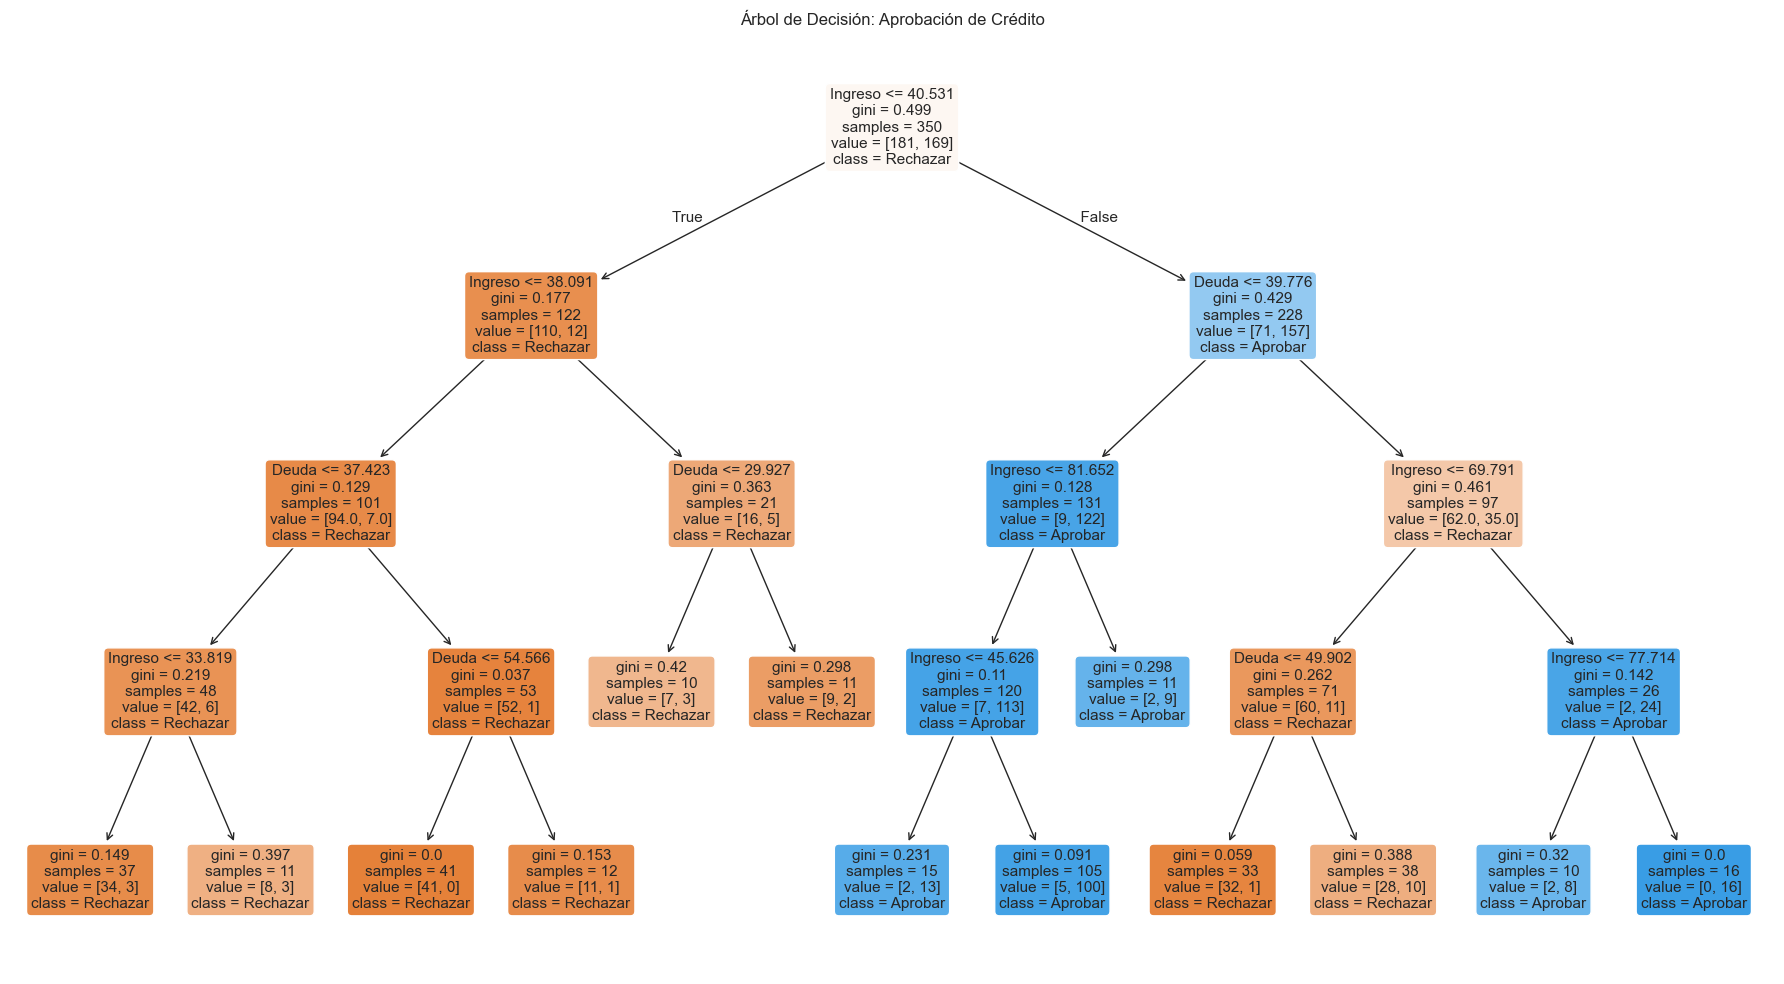

In [9]:
# Entrenar árbol interpretable
X_cred = df_credito[['Ingreso', 'Deuda']]
y_cred = df_credito['Aprobado']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cred, y_cred, test_size=0.3, random_state=RANDOM_STATE)

tree_credito = DecisionTreeClassifier(
    max_depth=4, min_samples_leaf=10, random_state=RANDOM_STATE)
tree_credito.fit(X_train_c, y_train_c)

# Visualizar árbol
plt.figure(figsize=(18, 10))
plot_tree(tree_credito,
          feature_names=['Ingreso', 'Deuda'],
          class_names=['Rechazar', 'Aprobar'],
          filled=True,
          rounded=True,
          fontsize=11)
plt.title('Árbol de Decisión: Aprobación de Crédito')
plt.tight_layout()
plt.show()


### 🧠 Interpretación para el Regulador

El árbol genera **reglas explícitas** que podemos explicar:

```
REGLA 1: Si Ingreso > 70k → APROBAR (clientes premium)
REGLA 2: Si Ingreso ≤ 70k Y Deuda > 40% → RECHAZAR (alto riesgo)
REGLA 3: Si Ingreso ≤ 70k Y Deuda ≤ 40% Y Ingreso > 40k → APROBAR
REGLA 4: Si Ingreso ≤ 40k → RECHAZAR (bajo ingreso)
```

> **⚠️ Real-World Warning: Fairness**
> En la vida real, debes verificar que las reglas no discriminen por variables protegidas (género, raza, edad). Los árboles pueden capturar sesgos históricos de los datos.

In [10]:
# Métricas
print("="*50)
print("📊 EVALUACIÓN DEL MODELO")
print("="*50)
print(f"Accuracy en Test: {tree_credito.score(X_test_c, y_test_c):.2%}")
print(f"Número de hojas: {tree_credito.get_n_leaves()}")
print("="*50)


📊 EVALUACIÓN DEL MODELO
Accuracy en Test: 90.00%
Número de hojas: 13


### 🧠 Micro-Desafío: Nueva Solicitud

* Un cliente con **Ingreso = \$55k** y **Deuda = 35%** solicita un crédito.
* Un cliente con **Ingreso = \$0k** y **Deuda = 10%** solicita un crédito.
**Pregunta:** ¿Qué predice el modelo? Sigue las ramas del árbol manualmente.

In [11]:
# ================================
# 🧠 TU TURNO: Micro-Desafío
# ================================
nuevo_cliente = pd.DataFrame({'Ingreso': [55], 'Deuda': [35]})
prediccion = tree_credito.predict(nuevo_cliente)[0]
proba = tree_credito.predict_proba(nuevo_cliente)[0]

print(f"📊 Predicción: {'✅ APROBAR' if prediccion == 1 else '❌ RECHAZAR'}")
print(f"📊 Probabilidades: Rechazar={proba[0]:.2%}, Aprobar={proba[1]:.2%}")


📊 Predicción: ✅ APROBAR
📊 Probabilidades: Rechazar=4.76%, Aprobar=95.24%


---

## 8. Resumen y Siguiente Paso

### 🏆 Resumen de Logros
¡Felicidades! En este notebook has aprendido:

1. **La Intuición:** Un árbol es una secuencia de preguntas binarias que divide el espacio.
2. **Fronteras Escalonadas:** Los árboles crean divisiones paralelas a los ejes.
3. **Overfitting:** Sin restricciones, el árbol memoriza el ruido (100% train, bajo test).
4. **Poda:** `max_depth`, `min_samples_leaf` controlan la complejidad.
5. **Interpretabilidad:** Las reglas If-Then son fáciles de explicar a stakeholders.

### ⚠️ Limitaciones de un Árbol Solo
- **Alta varianza:** Pequeños cambios en datos → árbol muy diferente.
- **Fronteras dentadas:** No captura bien curvas suaves.
- **Inestabilidad:** Un outlier puede cambiar toda la estructura.

---

### 👉 Siguiente Paso
¿Cómo solucionamos la alta varianza de un árbol solo? 

**Random Forest:** Entrenar muchos árboles y promediar sus predicciones. *"Un experto se equivoca, mil promediados no."*

*En el siguiente notebook veremos cómo el Bagging reduce la varianza sin aumentar el sesgo.*

# Clasificación Binaria (Sí/No) Multiclase (Llover, Sol, Viento)
# Regresión valor continuo: precio de una vivienda

Arboles de decisión: clasificación y regresión

In [ ]:
import dtreeviz
viz_model = dtreeviz.model(tree_credito,
                           X_train=X_cred, y_train=y_cred,
                           target_name='Aprobado',
                           feature_names=['Ingreso', 'Deuda'],
                           class_names=['Rechazar', 'Aprobar'],)

viz_model.view()     # render as SVG into internal object 
v.show()                 # pop up window
#v.save("/tmp/iris.svg")  # optionally save as svg

c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustab

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x

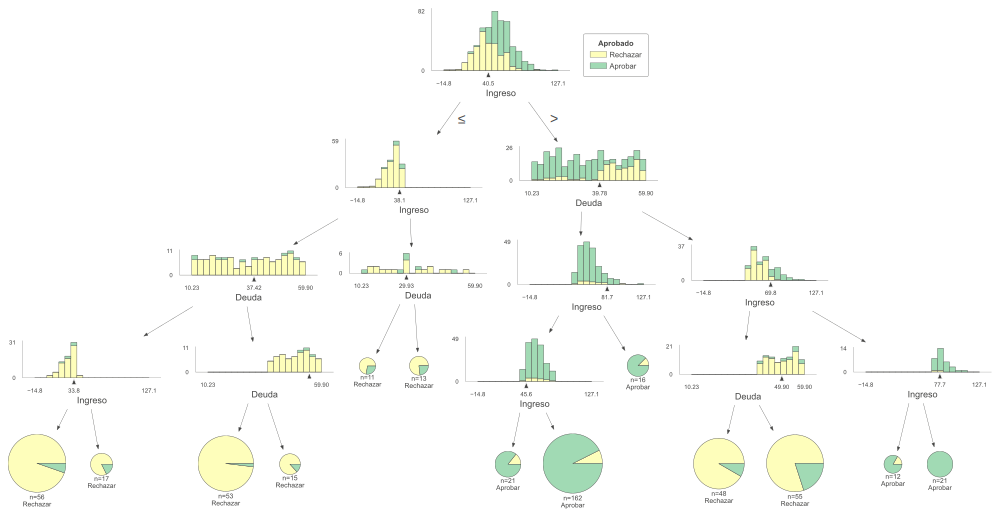

In [14]:
viz_model.view()